# MNIST Autoencoder with Vector Quantization (VQ-VAE)

This notebook implements a Vector Quantized Variational Autoencoder (VQ-VAE) for MNIST digit compression and reconstruction. The model uses a vector quantization layer at the bottleneck to learn discrete representations of the input images.

## Key Components:
1. **Encoder**: Compresses MNIST images to latent representations
2. **Vector Quantization Layer**: Discretizes the latent space using learnable codebook vectors
3. **Decoder**: Reconstructs images from quantized representations
4. **Training Loop**: Includes reconstruction loss and vector quantization losses

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np
from typing import Tuple

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)

Using device: cuda


In [2]:
class VectorQuantizer(nn.Module):
    """
    Vector Quantization layer for VQ-VAE.
    
    Args:
        num_embeddings: Number of vectors in the codebook
        embedding_dim: Dimension of each codebook vector
        commitment_cost: Weight for commitment loss
    """
    def __init__(self, num_embeddings: int, embedding_dim: int, commitment_cost: float = 0.25):
        super(VectorQuantizer, self).__init__()
        
        self.embedding_dim = embedding_dim
        self.num_embeddings = num_embeddings
        self.commitment_cost = commitment_cost
        
        # Initialize embedding table
        self.embedding = nn.Embedding(num_embeddings, embedding_dim)
        self.embedding.weight.data.uniform_(-1/num_embeddings, 1/num_embeddings)
        
    def forward(self, inputs):
        # Convert inputs from BCHW -> BHWC
        inputs = inputs.permute(0, 2, 3, 1).contiguous()
        input_shape = inputs.shape
        
        # Flatten input
        flat_input = inputs.view(-1, self.embedding_dim)
        
        # Calculate distances between input and embedding vectors
        distances = (torch.sum(flat_input**2, dim=1, keepdim=True) 
                    + torch.sum(self.embedding.weight**2, dim=1)
                    - 2 * torch.matmul(flat_input, self.embedding.weight.t()))
        
        # Get closest embedding indices
        encoding_indices = torch.argmin(distances, dim=1).unsqueeze(1)
        encodings = torch.zeros(encoding_indices.shape[0], self.num_embeddings, device=inputs.device)
        encodings.scatter_(1, encoding_indices, 1)
        
        # Quantize and unflatten
        quantized = torch.matmul(encodings, self.embedding.weight).view(input_shape)
        
        # Loss terms
        e_latent_loss = F.mse_loss(quantized.detach(), inputs)
        q_latent_loss = F.mse_loss(quantized, inputs.detach())
        loss = q_latent_loss + self.commitment_cost * e_latent_loss
        
        # Straight through estimator
        quantized = inputs + (quantized - inputs).detach()
        avg_probs = torch.mean(encodings, dim=0)
        perplexity = torch.exp(-torch.sum(avg_probs * torch.log(avg_probs + 1e-10)))
        
        # Convert back to BCHW
        return quantized.permute(0, 3, 1, 2).contiguous(), loss, perplexity

In [3]:
class Encoder(nn.Module):
    """
    Encoder network for VQ-VAE.
    Compresses 28x28 MNIST images to latent representations.
    """
    def __init__(self, in_channels: int = 1, hidden_dim: int = 128, embedding_dim: int = 64):
        super(Encoder, self).__init__()
        
        self.conv_layers = nn.Sequential(
            # First conv block: 28x28 -> 14x14
            nn.Conv2d(in_channels, 32, kernel_size=4, stride=2, padding=1),
            nn.ReLU(inplace=True),
            
            # Second conv block: 14x14 -> 7x7
            nn.Conv2d(32, 64, kernel_size=4, stride=2, padding=1),
            nn.ReLU(inplace=True),
            
            # Third conv block: 7x7 -> 7x7 (same size)
            nn.Conv2d(64, hidden_dim, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            
            # Final conv to embedding dimension
            nn.Conv2d(hidden_dim, embedding_dim, kernel_size=1),
        )
        
    def forward(self, x):
        return self.conv_layers(x)

In [4]:
class Decoder(nn.Module):
    """
    Decoder network for VQ-VAE.
    Reconstructs 28x28 MNIST images from quantized latent representations.
    """
    def __init__(self, embedding_dim: int = 64, hidden_dim: int = 128, out_channels: int = 1):
        super(Decoder, self).__init__()
        
        self.conv_layers = nn.Sequential(
            # First conv: embedding_dim -> hidden_dim
            nn.Conv2d(embedding_dim, hidden_dim, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            
            # Second conv: maintain hidden_dim
            nn.Conv2d(hidden_dim, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            
            # First upsampling: 7x7 -> 14x14
            nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1),
            nn.ReLU(inplace=True),
            
            # Second upsampling: 14x14 -> 28x28
            nn.ConvTranspose2d(32, out_channels, kernel_size=4, stride=2, padding=1),
            nn.Sigmoid()  # Output values between 0 and 1
        )
        
    def forward(self, x):
        return self.conv_layers(x)

In [5]:
class VQVAE(nn.Module):
    """
    Complete VQ-VAE model combining Encoder, VectorQuantizer, and Decoder.
    """
    def __init__(self, 
                 num_embeddings: int = 512, 
                 embedding_dim: int = 64, 
                 commitment_cost: float = 0.25,
                 hidden_dim: int = 128):
        super(VQVAE, self).__init__()
        
        self.encoder = Encoder(embedding_dim=embedding_dim, hidden_dim=hidden_dim)
        self.vq_layer = VectorQuantizer(num_embeddings, embedding_dim, commitment_cost)
        self.decoder = Decoder(embedding_dim=embedding_dim, hidden_dim=hidden_dim)
        
    def forward(self, x):
        # Encode
        z_e = self.encoder(x)
        
        # Vector quantize
        z_q, vq_loss, perplexity = self.vq_layer(z_e)
        
        # Decode
        x_recon = self.decoder(z_e)
        
        return x_recon, vq_loss, perplexity
    
    def encode(self, x):
        """Encode input to quantized latent codes"""
        z_e = self.encoder(x)
        z_q, _, _ = self.vq_layer(z_e)
        return z_q
    
    def decode(self, z_q):
        """Decode quantized latent codes to reconstruction"""
        return self.decoder(z_q)

Training samples: 60000
Test samples: 10000
Batch size: 128


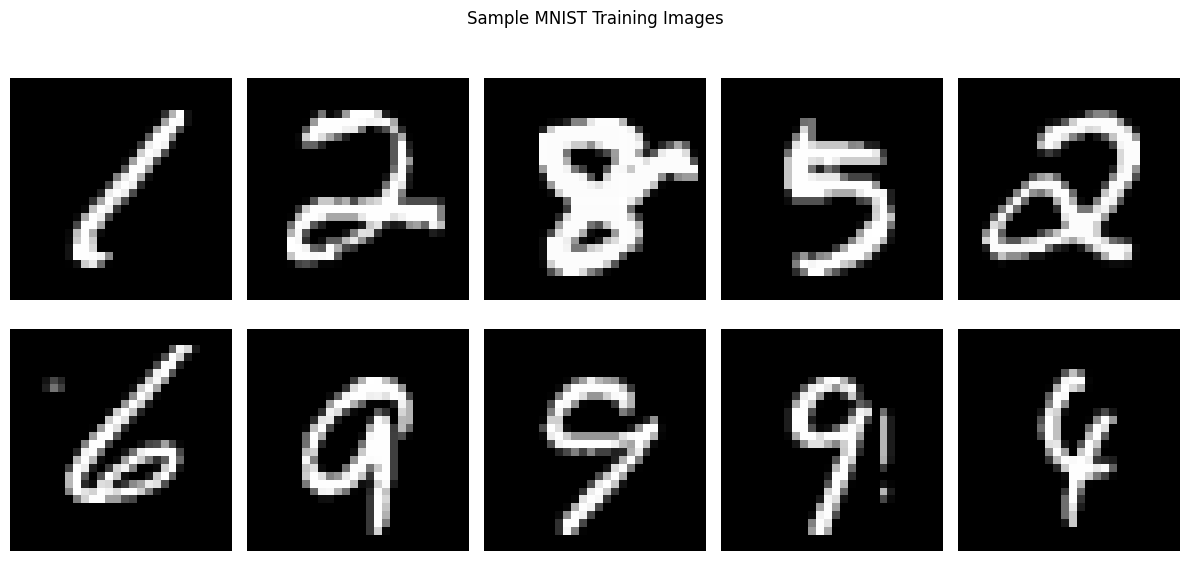

In [6]:
# Data loading and preprocessing
transform = transforms.Compose([
    transforms.ToTensor(),
    # Note: MNIST is already normalized to [0,1], no need for additional normalization
])

# Load MNIST dataset
train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

# Create data loaders
batch_size = 128
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

print(f"Training samples: {len(train_dataset)}")
print(f"Test samples: {len(test_dataset)}")
print(f"Batch size: {batch_size}")

# Visualize some sample images
def show_images(images, title="Sample Images", nrows=2, ncols=5):
    fig, axes = plt.subplots(nrows, ncols, figsize=(12, 6))
    for i, ax in enumerate(axes.flat):
        if i < len(images):
            ax.imshow(images[i].squeeze(), cmap='gray')
            ax.axis('off')
        else:
            ax.axis('off')
    plt.suptitle(title)
    plt.tight_layout()
    plt.show()

# Show sample training images
sample_batch, _ = next(iter(train_loader))
show_images(sample_batch[:10], "Sample MNIST Training Images")

In [7]:
# Model initialization
model = VQVAE(
    num_embeddings=512,    # Size of the codebook
    embedding_dim=64,      # Dimension of each codebook vector
    commitment_cost=0.25,  # Weight for commitment loss
    hidden_dim=128         # Hidden dimension in encoder/decoder
).to(device)

# Optimizer
optimizer = optim.Adam(model.parameters(), lr=1e-3)

# Print model information
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"Total parameters: {total_params:,}")
print(f"Trainable parameters: {trainable_params:,}")
print(f"Model: {model}")

# Test forward pass
with torch.no_grad():
    test_input = torch.randn(1, 1, 28, 28).to(device)
    test_output, test_vq_loss, test_perplexity = model(test_input)
    print(f"\nTest forward pass:")
    print(f"Input shape: {test_input.shape}")
    print(f"Output shape: {test_output.shape}")
    print(f"VQ loss: {test_vq_loss.item():.4f}")
    print(f"Perplexity: {test_perplexity.item():.4f}")

Total parameters: 329,217
Trainable parameters: 329,217
Model: VQVAE(
  (encoder): Encoder(
    (conv_layers): Sequential(
      (0): Conv2d(1, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (1): ReLU(inplace=True)
      (2): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (3): ReLU(inplace=True)
      (4): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (5): ReLU(inplace=True)
      (6): Conv2d(128, 64, kernel_size=(1, 1), stride=(1, 1))
    )
  )
  (vq_layer): VectorQuantizer(
    (embedding): Embedding(512, 64)
  )
  (decoder): Decoder(
    (conv_layers): Sequential(
      (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU(inplace=True)
      (2): Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): ReLU(inplace=True)
      (4): ConvTranspose2d(64, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (5): ReLU(inplace=True)
      (6): ConvTranspose2d(3

In [8]:
inputs = next(iter(train_loader))[0].to(device)


In [9]:
e= model.encoder(inputs)

In [10]:
e.shape

torch.Size([128, 64, 7, 7])

In [11]:
self = model.vq_layer
inputs = e.permute(0, 2, 3, 1).contiguous()
input_shape = inputs.shape

# Flatten input
flat_input = inputs.view(-1, self.embedding_dim)

# Calculate distances between input and embedding vectors
distances = (torch.sum(flat_input**2, dim=1, keepdim=True) 
            + torch.sum(self.embedding.weight**2, dim=1)
            - 2 * torch.matmul(flat_input, self.embedding.weight.t()))

# Get closest embedding indices
encoding_indices = torch.argmin(distances, dim=1).unsqueeze(1)
encodings = torch.zeros(encoding_indices.shape[0], self.num_embeddings, device=inputs.device)
encodings.scatter_(1, encoding_indices, 1)

# Quantize and unflatten
quantized = torch.matmul(encodings, self.embedding.weight).view(input_shape)

# Loss terms
e_latent_loss = F.mse_loss(quantized.detach(), inputs)
q_latent_loss = F.mse_loss(quantized, inputs.detach())
loss = q_latent_loss + self.commitment_cost * e_latent_loss

# Straight through estimator
quantized = inputs + (quantized - inputs).detach()
avg_probs = torch.mean(encodings, dim=0)
perplexity = torch.exp(-torch.sum(avg_probs * torch.log(avg_probs + 1e-10)))

# Convert back to BCHW
o =  quantized.permute(0, 3, 1, 2).contiguous(), loss, perplexity

In [12]:
# avg_probs

In [13]:
flat_input.shape

torch.Size([6272, 64])

In [14]:
encodings.shape

torch.Size([6272, 512])

In [22]:
model

VQVAE(
  (encoder): Encoder(
    (conv_layers): Sequential(
      (0): Conv2d(1, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (1): ReLU(inplace=True)
      (2): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (3): ReLU(inplace=True)
      (4): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (5): ReLU(inplace=True)
      (6): Conv2d(128, 64, kernel_size=(1, 1), stride=(1, 1))
    )
  )
  (vq_layer): VectorQuantizer(
    (embedding): Embedding(512, 64)
  )
  (decoder): Decoder(
    (conv_layers): Sequential(
      (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU(inplace=True)
      (2): Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): ReLU(inplace=True)
      (4): ConvTranspose2d(64, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (5): ReLU(inplace=True)
      (6): ConvTranspose2d(32, 1, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      

In [16]:
def train_epoch(model, train_loader, optimizer, device):
    """Train the model for one epoch"""
    model.train()
    total_loss = 0
    total_recon_loss = 0
    total_vq_loss = 0
    total_perplexity = 0
    
    for batch_idx, (data, _) in enumerate(train_loader):
        data = data.to(device)
        
        optimizer.zero_grad()
        
        # Forward pass
        recon_data, vq_loss, perplexity = model(data)
        
        # Reconstruction loss (MSE)
        recon_loss = F.mse_loss(recon_data, data)
        
        # Total loss
        loss = recon_loss # + vq_loss
        
        # Backward pass
        loss.backward()
        optimizer.step()
        
        # Accumulate metrics
        total_loss += loss.item()
        total_recon_loss += recon_loss.item()
        total_vq_loss += vq_loss.item()
        total_perplexity += perplexity.item()
        
        if batch_idx % 100 == 0:
            print(f'Batch {batch_idx}/{len(train_loader)}: '
                  f'Loss: {loss.item():.4f}, '
                  f'Recon: {recon_loss.item():.4f}, '
                  f'VQ: {vq_loss.item():.4f}, '
                  f'Perplexity: {perplexity.item():.2f}')
    
    # Return average metrics
    num_batches = len(train_loader)
    return (total_loss / num_batches, 
            total_recon_loss / num_batches, 
            total_vq_loss / num_batches, 
            total_perplexity / num_batches)

In [17]:
def evaluate(model, test_loader, device):
    """Evaluate the model on test set"""
    model.eval()
    total_loss = 0
    total_recon_loss = 0
    total_vq_loss = 0
    total_perplexity = 0
    
    with torch.no_grad():
        for data, _ in test_loader:
            data = data.to(device)
            
            # Forward pass
            recon_data, vq_loss, perplexity = model(data)
            
            # Reconstruction loss
            recon_loss = F.mse_loss(recon_data, data)
            
            # Total loss
            loss = recon_loss + vq_loss
            
            # Accumulate metrics
            total_loss += loss.item()
            total_recon_loss += recon_loss.item()
            total_vq_loss += vq_loss.item()
            total_perplexity += perplexity.item()
    
    # Return average metrics
    num_batches = len(test_loader)
    return (total_loss / num_batches, 
            total_recon_loss / num_batches, 
            total_vq_loss / num_batches, 
            total_perplexity / num_batches)

In [18]:
# Training loop
num_epochs = 1000
train_losses = []
test_losses = []
perplexities = []

print("Starting training...")
print("-" * 60)

for epoch in range(num_epochs):
    print(f"\nEpoch {epoch + 1}/{num_epochs}")
    print("-" * 40)
    
    # Train for one epoch
    train_loss, train_recon, train_vq, train_perp = train_epoch(
        model, train_loader, optimizer, device
    )
    
    # Evaluate on test set
    test_loss, test_recon, test_vq, test_perp = evaluate(
        model, test_loader, device
    )
    
    # Store metrics
    train_losses.append(train_loss)
    test_losses.append(test_loss)
    perplexities.append(test_perp)
    
    # Print epoch summary
    print(f"\nEpoch {epoch + 1} Summary:")
    print(f"Train - Loss: {train_loss:.4f}, Recon: {train_recon:.4f}, VQ: {train_vq:.4f}, Perp: {train_perp:.2f}")
    print(f"Test  - Loss: {test_loss:.4f}, Recon: {test_recon:.4f}, VQ: {test_vq:.4f}, Perp: {test_perp:.2f}")

print("\nTraining completed!")

# Plot training curves
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# Loss curves
ax1.plot(range(1, num_epochs + 1), train_losses, 'b-', label='Train Loss')
ax1.plot(range(1, num_epochs + 1), test_losses, 'r-', label='Test Loss')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.set_title('Training and Test Loss')
ax1.legend()
ax1.grid(True)

# Perplexity curve
ax2.plot(range(1, num_epochs + 1), perplexities, 'g-', label='Test Perplexity')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Perplexity')
ax2.set_title('Codebook Perplexity')
ax2.legend()
ax2.grid(True)

plt.tight_layout()
plt.show()

Starting training...
------------------------------------------------------------

Epoch 1/1000
----------------------------------------
Batch 0/469: Loss: 0.1887, Recon: 0.1887, VQ: 0.0030, Perplexity: 3.15
Batch 100/469: Loss: 0.1117, Recon: 0.1117, VQ: 79.2076, Perplexity: 1.00
Batch 200/469: Loss: 0.1100, Recon: 0.1100, VQ: 78.8801, Perplexity: 1.00
Batch 300/469: Loss: 0.1119, Recon: 0.1119, VQ: 79.4916, Perplexity: 1.00
Batch 400/469: Loss: 0.1091, Recon: 0.1091, VQ: 78.6437, Perplexity: 1.00

Epoch 1 Summary:
Train - Loss: 0.1129, Recon: 0.1129, VQ: 74.2991, Perp: 1.01
Test  - Loss: 80.2677, Recon: 0.1143, VQ: 80.1534, Perp: 1.00

Epoch 2/1000
----------------------------------------
Batch 0/469: Loss: 0.1183, Recon: 0.1183, VQ: 81.6808, Perplexity: 1.00
Batch 100/469: Loss: 0.1103, Recon: 0.1103, VQ: 78.8452, Perplexity: 1.00
Batch 200/469: Loss: 0.1041, Recon: 0.1041, VQ: 76.5701, Perplexity: 1.00
Batch 300/469: Loss: 0.1177, Recon: 0.1177, VQ: 80.9202, Perplexity: 1.00
Batch 

KeyboardInterrupt: 

Visualizing reconstructions...


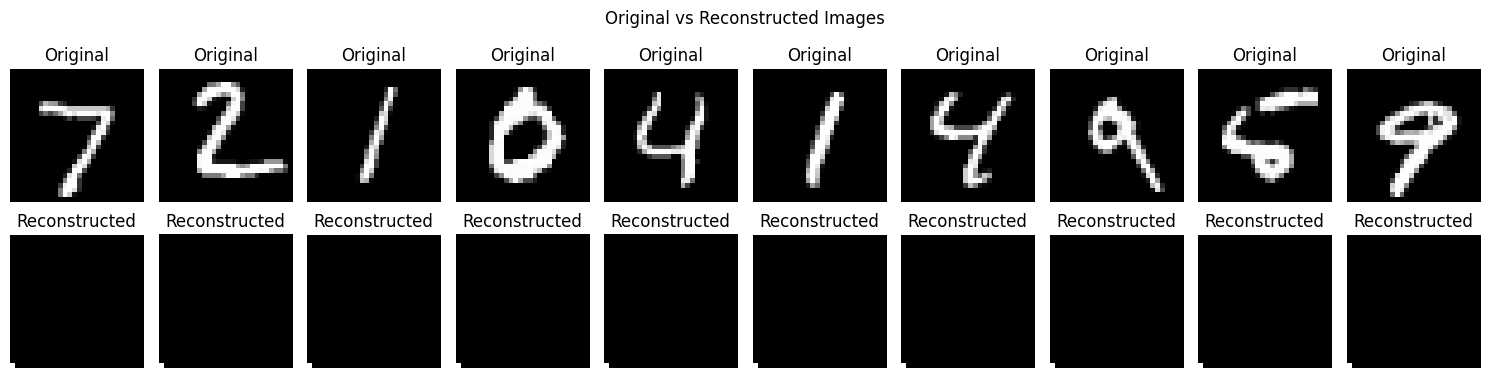


Analyzing codebook usage...
Codebook Analysis:
Total codebook size: 512
Codes used: 1 (0.2%)
Most used code frequency: 490000
Least used code frequency: 0


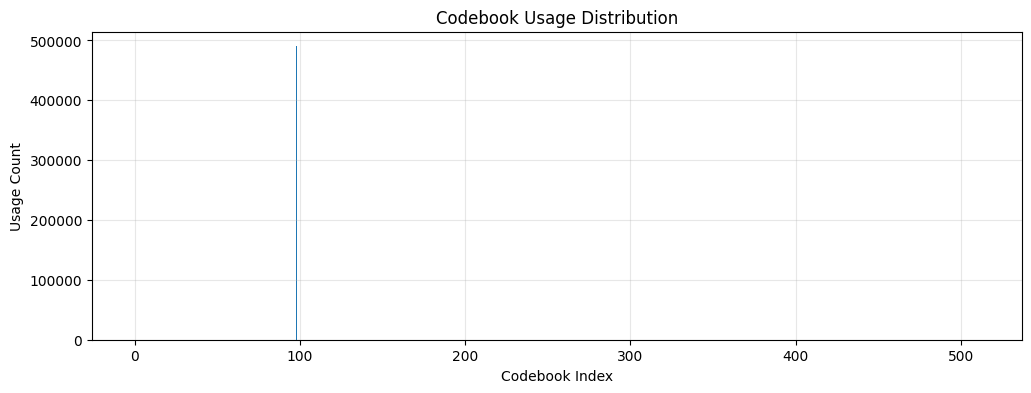

In [19]:
def visualize_reconstructions(model, test_loader, device, num_samples=10):
    """Visualize original images and their reconstructions"""
    model.eval()
    
    # Get a batch of test images
    data, _ = next(iter(test_loader))
    data = data[:num_samples].to(device)
    
    with torch.no_grad():
        reconstructions, _, _ = model(data)
    
    # Move to CPU for plotting
    originals = data.cpu()
    reconstructions = reconstructions.cpu()
    
    # Create comparison plot
    fig, axes = plt.subplots(2, num_samples, figsize=(15, 4))
    
    for i in range(num_samples):
        # Original images
        axes[0, i].imshow(originals[i].squeeze(), cmap='gray')
        axes[0, i].set_title('Original')
        axes[0, i].axis('off')
        
        # Reconstructed images
        axes[1, i].imshow(reconstructions[i].squeeze(), cmap='gray')
        axes[1, i].set_title('Reconstructed')
        axes[1, i].axis('off')
    
    plt.suptitle('Original vs Reconstructed Images')
    plt.tight_layout()
    plt.show()

def analyze_codebook_usage(model, test_loader, device):
    """Analyze how much of the codebook is being used"""
    model.eval()
    
    # Collect all encoding indices
    encoding_indices = []
    
    with torch.no_grad():
        for data, _ in test_loader:
            data = data.to(device)
            
            # Get encoded representation
            z_e = model.encoder(data)
            
            # Get quantized representation and indices
            z_e_permuted = z_e.permute(0, 2, 3, 1).contiguous()
            flat_input = z_e_permuted.view(-1, model.vq_layer.embedding_dim)
            
            # Calculate distances and get indices
            distances = (torch.sum(flat_input**2, dim=1, keepdim=True) 
                        + torch.sum(model.vq_layer.embedding.weight**2, dim=1)
                        - 2 * torch.matmul(flat_input, model.vq_layer.embedding.weight.t()))
            
            indices = torch.argmin(distances, dim=1)
            encoding_indices.append(indices.cpu())
    
    # Combine all indices
    all_indices = torch.cat(encoding_indices)
    
    # Count unique codes used
    unique_codes = torch.unique(all_indices)
    usage_counts = torch.bincount(all_indices, minlength=model.vq_layer.num_embeddings)
    
    print(f"Codebook Analysis:")
    print(f"Total codebook size: {model.vq_layer.num_embeddings}")
    print(f"Codes used: {len(unique_codes)} ({len(unique_codes)/model.vq_layer.num_embeddings*100:.1f}%)")
    print(f"Most used code frequency: {usage_counts.max().item()}")
    print(f"Least used code frequency: {usage_counts.min().item()}")
    
    # Plot codebook usage
    plt.figure(figsize=(12, 4))
    plt.bar(range(len(usage_counts)), usage_counts.numpy())
    plt.xlabel('Codebook Index')
    plt.ylabel('Usage Count')
    plt.title('Codebook Usage Distribution')
    plt.grid(True, alpha=0.3)
    plt.show()
    
    return usage_counts

# Visualize reconstructions
print("Visualizing reconstructions...")
visualize_reconstructions(model, test_loader, device)

# Analyze codebook usage
print("\nAnalyzing codebook usage...")
usage_counts = analyze_codebook_usage(model, test_loader, device)

Performing latent space interpolation...


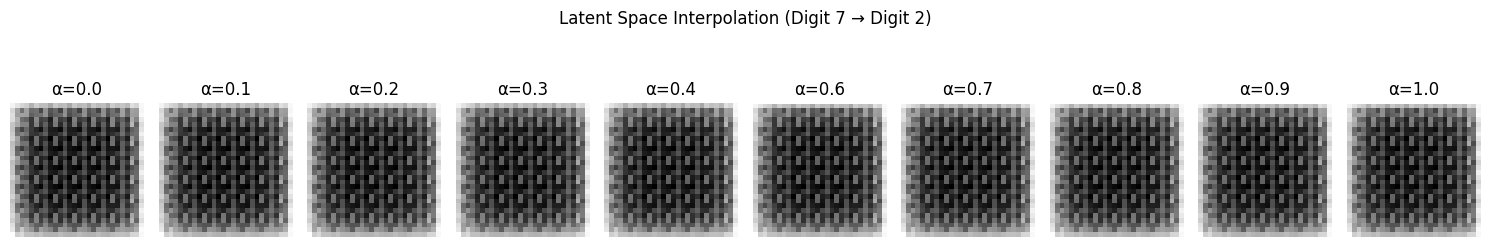


Generating random samples...


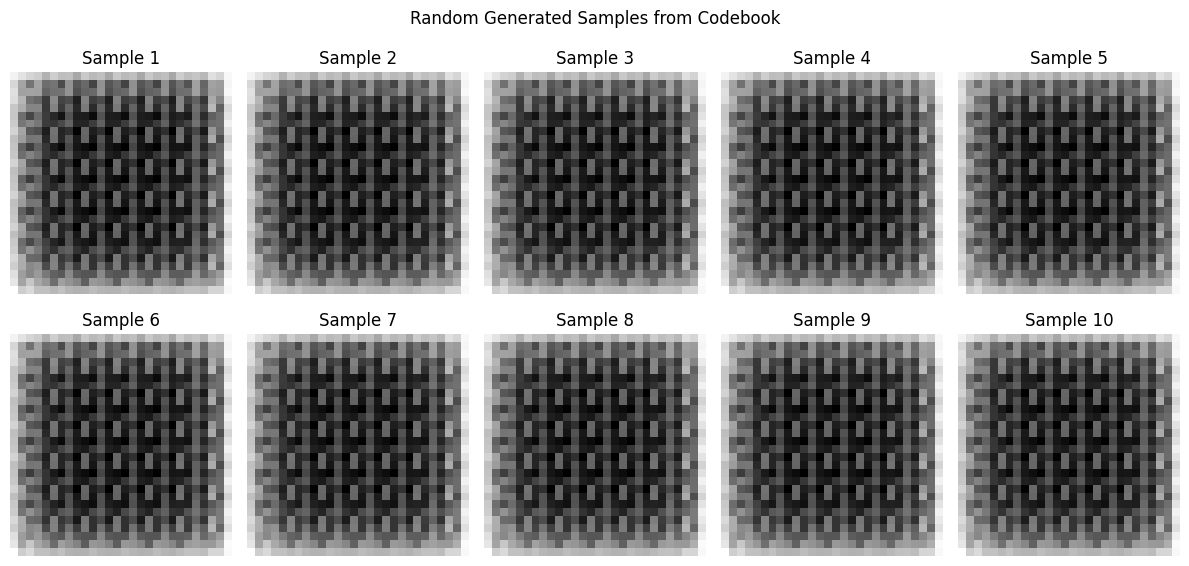

In [20]:
def interpolate_latent_space(model, test_loader, device, steps=10):
    """Interpolate between two images in the quantized latent space"""
    model.eval()
    
    # Get two random test images
    data, labels = next(iter(test_loader))
    img1, img2 = data[0:1].to(device), data[1:2].to(device)
    
    with torch.no_grad():
        # Encode both images
        z1 = model.encode(img1)
        z2 = model.encode(img2)
        
        # Create interpolation
        interpolated_images = []
        
        for i in range(steps):
            alpha = i / (steps - 1)
            # Linear interpolation in latent space
            z_interp = (1 - alpha) * z1 + alpha * z2
            
            # Decode interpolated latent
            img_interp = model.decode(z_interp)
            interpolated_images.append(img_interp.cpu().squeeze())
    
    # Visualize interpolation
    fig, axes = plt.subplots(1, steps, figsize=(15, 3))
    for i, img in enumerate(interpolated_images):
        axes[i].imshow(img, cmap='gray')
        axes[i].set_title(f'α={i/(steps-1):.1f}')
        axes[i].axis('off')
    
    plt.suptitle(f'Latent Space Interpolation (Digit {labels[0]} → Digit {labels[1]})')
    plt.tight_layout()
    plt.show()

def generate_random_samples(model, device, num_samples=10):
    """Generate random samples by using random codebook vectors"""
    model.eval()
    
    with torch.no_grad():
        # Create random latent codes by sampling from the codebook
        batch_size = num_samples
        height, width = 7, 7  # Latent space dimensions
        embedding_dim = model.vq_layer.embedding_dim
        
        # Sample random codebook indices
        random_indices = torch.randint(0, model.vq_layer.num_embeddings, 
                                     (batch_size, height, width)).to(device)
        
        # Get corresponding embeddings
        random_codes = model.vq_layer.embedding(random_indices)
        
        # Reshape to proper format for decoder: (B, H, W, C) -> (B, C, H, W)
        random_latents = random_codes.permute(0, 3, 1, 2)
        
        # Decode to generate images
        generated_images = model.decode(random_latents)
    
    # Visualize generated samples
    fig, axes = plt.subplots(2, 5, figsize=(12, 6))
    for i, ax in enumerate(axes.flat):
        if i < num_samples:
            ax.imshow(generated_images[i].cpu().squeeze(), cmap='gray')
            ax.set_title(f'Sample {i+1}')
        ax.axis('off')
    
    plt.suptitle('Random Generated Samples from Codebook')
    plt.tight_layout()
    plt.show()

# Perform latent space interpolation
print("Performing latent space interpolation...")
interpolate_latent_space(model, test_loader, device)

# Generate random samples
print("\nGenerating random samples...")
generate_random_samples(model, device)

In [21]:
def analyze_compression(model, test_loader, device):
    """Analyze the compression achieved by the VQ-VAE"""
    model.eval()
    
    # Original image dimensions
    original_size = 28 * 28  # pixels per image
    
    # Latent representation dimensions
    latent_height, latent_width = 7, 7  # from encoder output
    codebook_size = model.vq_layer.num_embeddings
    
    # Bits needed to represent each latent position
    bits_per_position = np.log2(codebook_size)
    
    # Total bits for latent representation
    latent_bits = latent_height * latent_width * bits_per_position
    
    # Compression ratio
    compression_ratio = original_size * 8 / latent_bits  # assuming 8 bits per pixel originally
    
    print("Compression Analysis:")
    print("-" * 40)
    print(f"Original image size: {original_size} pixels")
    print(f"Latent representation: {latent_height} × {latent_width} positions")
    print(f"Codebook size: {codebook_size} vectors")
    print(f"Bits per latent position: {bits_per_position:.2f}")
    print(f"Total latent bits: {latent_bits:.2f}")
    print(f"Compression ratio: {compression_ratio:.2f}:1")
    print(f"Compression percentage: {100/compression_ratio:.1f}% of original size")
    
    # Calculate actual reconstruction quality
    total_mse = 0
    total_samples = 0
    
    with torch.no_grad():
        for data, _ in test_loader:
            data = data.to(device)
            recon_data, _, _ = model(data)
            
            mse = F.mse_loss(recon_data, data, reduction='sum')
            total_mse += mse.item()
            total_samples += data.size(0)
    
    avg_mse = total_mse / total_samples
    avg_psnr = 10 * np.log10(1.0 / avg_mse) if avg_mse > 0 else float('inf')
    
    print(f"\nReconstruction Quality:")
    print(f"Average MSE: {avg_mse:.6f}")
    print(f"Average PSNR: {avg_psnr:.2f} dB")

# Save the trained model
torch.save({
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'train_losses': train_losses,
    'test_losses': test_losses,
    'perplexities': perplexities,
    'num_embeddings': model.vq_layer.num_embeddings,
    'embedding_dim': model.vq_layer.embedding_dim,
    'commitment_cost': model.vq_layer.commitment_cost,
}, 'vqvae_mnist_model.pth')

print("Model saved as 'vqvae_mnist_model.pth'")

# Analyze compression
analyze_compression(model, test_loader, device)

Model saved as 'vqvae_mnist_model.pth'
Compression Analysis:
----------------------------------------
Original image size: 784 pixels
Latent representation: 7 × 7 positions
Codebook size: 512 vectors
Bits per latent position: 9.00
Total latent bits: 441.00
Compression ratio: 14.22:1
Compression percentage: 7.0% of original size

Reconstruction Quality:
Average MSE: 89.343155
Average PSNR: -19.51 dB
